# **EEG Data Classification of Cognitive States Using Deep Learning Models**

#Introduction
This task involves the analysis of EEG data to classify different cognitive states using advanced deep learning techniques. The data is sourced from the Mental Arithmetic Tasks Dataset available at PhysioNet. The goal is to implement and evaluate multiple deep learning models using the MNE library for data preprocessing and feature extraction, and TensorFlow for model building. The steps include loading the data, performing Power Spectral Density (PSD) analysis, extracting features, and implementing binary classification using deep learning models.

# Step-by-Step Implementation

###Step 1: Install Necessary Libraries
We start by installing the required libraries, which include mne for EEG data processing, tensorflow for building deep learning models, keras-tuner for hyperparameter tuning, and scikeras for integrating scikit-learn and Keras.

In [1]:
!pip install mne
!pip install tensorflow
!pip install keras-tuner
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 44.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible

###Step 2: Import Libraries
Next, we import the necessary libraries for data processing, model building, and evaluation.

In [2]:
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import kurtosis, skew
from sklearn.metrics import classification_report
import keras_tuner as kt


###Step 3: Define Paths to EDF Files for Each Subject
Here, we define the paths to the EEG data files for each subject. The dataset contains two files per subject, one for the background state and one for the task state.

In [24]:
# Define paths to EDF files for each subject
edf_files = {
    "background": ['/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject{:02d}_1.edf'.format(i) for i in range(1, 36)],
    "task": ['/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject{:02d}_2.edf'.format(i) for i in range(1, 36)]
}



###Step 4: Load Subject Information from CSV
We load additional subject information, such as age, gender, and other demographics, from a CSV file. This information will be used as additional features for the model.

In [21]:
# Load subject information from CSV
csv_file = '/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv'
subject_info = pd.read_csv(csv_file, delimiter='\t')


###Step 5: Initialize Lists for Features, Labels, and Subject Data
We initialize empty lists to store the features, labels, and subject data.

In [4]:
features = []
labels = []
subject_data = []


###Step 6: Loop Over Subjects to Load Data and Calculate PSD
In this step, we loop over each subject to load the EEG data, calculate the Power Spectral Density (PSD) for different frequency bands, and extract both frequency domain and time domain features.

In [5]:
# Loop over subjects
for i in range(35):
    # Load background and task data
    raw_background = mne.io.read_raw_edf(edf_files['background'][i], preload=True)
    raw_task = mne.io.read_raw_edf(edf_files['task'][i], preload=True)

    # Calculate PSD for background
    psds_background, freqs = mne.time_frequency.psd_array_welch(
        raw_background.get_data(), sfreq=raw_background.info['sfreq'], fmin=1, fmax=100, n_fft=2048
    )

    # Calculate PSD for task
    psds_task, freqs = mne.time_frequency.psd_array_welch(
        raw_task.get_data(), sfreq=raw_task.info['sfreq'], fmin=1, fmax=100, n_fft=2048
    )

    # Define frequency bands
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 100)
    }

    for band, (fmin, fmax) in bands.items():
        idx_band = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        band_psd_background = np.mean(psds_background[:, idx_band], axis=1)
        band_psd_task = np.mean(psds_task[:, idx_band], axis=1)

        # Time Domain Features for background
        time_domain_feats_background = []
        for channel_data in raw_background.get_data():
            time_domain_feats_background.extend([
                np.max(channel_data) - np.min(channel_data),  # peak-to-peak amplitude
                np.sum(np.diff(channel_data > 0)),  # zero crossings
                kurtosis(channel_data),  # Kurtosis
                skew(channel_data)  # Skewness
            ])

        # Time Domain Features for task
        time_domain_feats_task = []
        for channel_data in raw_task.get_data():
            time_domain_feats_task.extend([
                np.max(channel_data) - np.min(channel_data),  # peak-to-peak amplitude
                np.sum(np.diff(channel_data > 0)),  # zero crossings
                kurtosis(channel_data),  # Kurtosis
                skew(channel_data)  # Skewness
            ])

        # Append features and labels
        features.append(np.concatenate([band_psd_background, time_domain_feats_background]))
        labels.append(0)  # Label for background
        features.append(np.concatenate([band_psd_task, time_domain_feats_task]))
        labels.append(1)  # Label for task

        # Append subject information for EACH trial (background and task)
        subject_data.append(subject_info.iloc[i].tolist())
        subject_data.append(subject_info.iloc[i].tolist())


Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creatin

###Step 7: Convert Lists to NumPy Arrays
We convert the lists of features, labels, and subject data into NumPy arrays for easier manipulation and compatibility with machine learning libraries.

In [22]:
# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)
subject_data = np.array(subject_data)

###Step 8: One-Hot Encode Subject Data
We use OneHotEncoder to convert categorical subject data into numerical format, making it suitable for inclusion as input features in our models.

In [23]:

# Convert subject data to numerical using one-hot encoding (if needed)
encoder = OneHotEncoder(handle_unknown='ignore')
subject_data_encoded = encoder.fit_transform(subject_data).toarray()


###Step 9: Split Data into Train and Test Sets
We split the dataset into training and testing sets using an 80-20 split. This helps in evaluating the model's performance on unseen data.

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test, subject_train, subject_test = train_test_split(
    features, labels, subject_data_encoded, test_size=0.2, random_state=42
)


###Step 10: Reshape Data for EEGNet Input
We reshape the data to fit the input shape required by the EEGNet model, which expects a 4D input: (samples, channels, samples, 1).

In [8]:
# Reshape data for EEGNet input
Chans, Samples = features.shape[1], 1  # Adjust based on your data
X_train = X_train.reshape(X_train.shape[0], Chans, Samples, 1)
X_test = X_test.reshape(X_test.shape[0], Chans, Samples, 1)


###Step 11: Define EEGNet Model Function
We define the EEGNet model function with hyperparameters that can be tuned using Keras Tuner. The model includes convolutional layers, depthwise separable convolutions, and a final dense layer for classification.

In [9]:
# Define EEGNet model function
def build_eegnet_with_subject_info(hp):
    # Define hyperparameters
    dropoutRate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    kernLength = hp.Int('kern_length', min_value=32, max_value=128, step=32)
    F1 = hp.Int('f1', min_value=4, max_value=16, step=4)
    D = hp.Int('d', min_value=1, max_value=4, step=1)
    F2 = hp.Int('f2', min_value=8, max_value=32, step=8)
    norm_rate = hp.Float('norm_rate', min_value=0.25, max_value=1.0, step=0.25)

    # Model architecture
    input1 = layers.Input(shape=(Chans, Samples, 1))
    input2 = layers.Input(shape=(subject_data_encoded.shape[1],))

    block1 = layers.Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((1, 1))(block1)
    block1 = layers.Dropout(dropoutRate)(block1)

    block2 = layers.SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.GlobalAveragePooling2D()(block2)
    block2 = layers.Dropout(dropoutRate)(block2)

    merged = layers.concatenate([block2, input2])

    flatten = layers.Flatten(name='flatten')(merged)
    dense = layers.Dense(2, name='dense',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                     kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    softmax = layers.Activation('softmax', name='softmax')(dense)

    # Compile model with optimizer and loss function
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = models.Model(inputs=[input1, input2], outputs=softmax)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])

    return model


###Step 12: Initialize Keras Tuner and Search for Best Hyperparameters
We initialize the Keras Tuner with the defined model and search for the best hyperparameters using a validation set.

In [10]:
# Define the tuner
tuner = kt.Hyperband(
    build_eegnet_with_subject_info,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='eegnet_subject_tuning'
)


In [11]:
# Perform hyperparameter search
tuner.search([X_train, subject_train], y_train, epochs=30, validation_data=([X_test, subject_test], y_test))


Trial 90 Complete [00h 00m 13s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 45s


###Step 13: Evaluate Best Model
Finally, we retrieve the best model found during the hyperparameter search and evaluate it on the test set.

In [12]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


In [13]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


In [14]:
# Train the best model with additional callbacks if needed
history = best_model.fit(
    [X_train, subject_train], y_train,
    batch_size=16, epochs=100,  # Adjust epochs as needed
    validation_data=([X_test, subject_test], y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9868 - loss: 0.1820 - val_accuracy: 1.0000 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9928 - loss: 0.1604 - val_accuracy: 0.9857 - val_loss: 0.4526 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9922 - loss: 0.1537 - val_accuracy: 0.9857 - val_loss: 0.4149 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9832 - loss: 0.1830 - val_accuracy: 0.9857 - val_loss: 0.3787 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9826 - loss: 0.1638 - val_accuracy: 0.9857 - val_loss: 0.3465 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9665 - loss: 0.1637 - val_accuracy: 0.9857 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.98

In [15]:
# Evaluate the best model
loss, accuracy = best_model.evaluate([X_test, subject_test], y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Predict classes
y_pred = best_model.predict([X_test, subject_test])
y_pred_classes = np.argmax(y_pred, axis=-1)

# Generate classification report
report = classification_report(y_test, y_pred_classes)
print(report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9811 - loss: 0.0460 
Test Accuracy: 0.99
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.97      1.00      0.99        38

    accuracy                           0.99        70
   macro avg       0.99      0.98      0.99        70
weighted avg       0.99      0.99      0.99        70



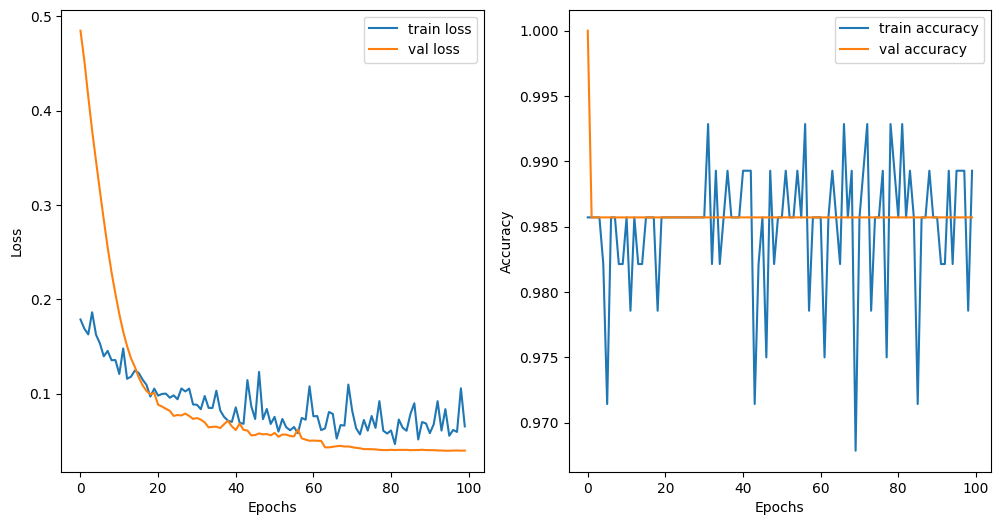

In [16]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


===================================================================================================================